# Import Packages

In [60]:
import matplotlib.pyplot as plt
from utils import create_dataset,model_plot,history_plot, read_data, plot_data, prepare_train_test_data
import numpy as np
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [61]:
clean_df, data = read_data('Totals.csv', debug=True)

         Date  Subscribers
0  2023-04-04            0
1  2023-04-05            0
2  2023-04-06            0
3  2023-04-07            0
4  2023-04-08            0
5  2023-04-09            0
6  2023-04-10            0
7  2023-04-11            0
8  2023-04-12            0
9  2023-04-13            0
----------------------------------------------------
        Date  Subscribers
0 2023-04-04            0
1 2023-04-05            0
2 2023-04-06            0
3 2023-04-07            0
4 2023-04-08            0
5 2023-04-09            0
6 2023-04-10            0
7 2023-04-11            0
8 2023-04-12            0
9 2023-04-13            0


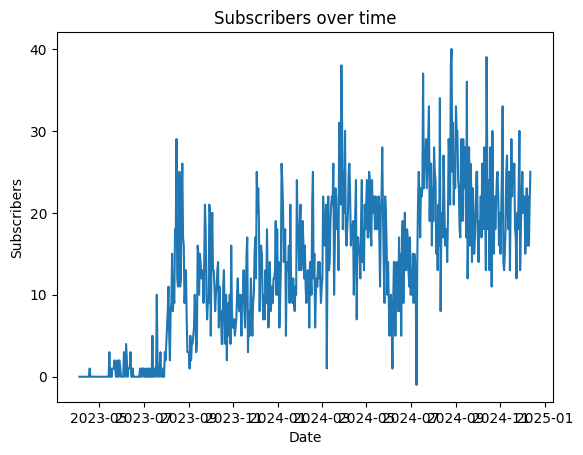

In [62]:
plot_data(clean_df["Subscribers"], title="Subscribers over time", x_label="Date", y_label="Subscribers")

In [63]:
x_train, x_test, y_train, y_test, scaler = prepare_train_test_data(data, time_step_in=7, time_step_out=7, test_size=0.2,shuffle=False)

x_train shape: (484, 7), y_train shape: (484, 7), x_test shape: (121, 7), y_test shape: (121, 7)


In [64]:
model_1=Sequential()
model_1.add(Dense(256,input_shape=(7,),activation="relu"))
model_1.add(Dense(128,activation="relu"))
model_1.add(Dense(64,activation="relu"))
model_1.add(Dense(32,activation="relu"))
model_1.add(Dense(7))
model_1.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])
model_1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 256)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,511 (177.78 KB)

 Trainable params: 45,511 (177.78 KB)

 Non-trainable params: 0 (0.00 B)

# Cross Validation

In [65]:
tscv = TimeSeriesSplit(n_splits=5)
loss_total = []

for i, (train_index, test_index) in enumerate(tscv.split(x_train), 1):
    X_tr, X_val = x_train[train_index], x_train[test_index]
    y_tr, y_val = y_train[train_index], y_train[test_index]
    
    history = model_1.fit(
        X_tr, y_tr,  
        epochs=100, 
        validation_data=(X_val, y_val),  
        verbose=0  
    )
    
    y_pred = model_1.predict(X_val)
    loss = mean_absolute_error(y_val, y_pred)
    loss_total.append(loss)
    
  
    print(f"Fold {i}:")
    print(f"  Training data size: {X_tr.shape}")
    print(f"  Validation data size: {X_val.shape}")
    print(f"  MAE: {loss:.4f}")
    print("-" * 30)


mean_loss = np.mean(loss_total)
print(f'\nMean Loss (MAE) over all folds: {mean_loss:.4f}')


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Fold 1:
  Training data size: (84, 7)
  Validation data size: (80, 7)
  MAE: 0.1397
------------------------------
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 2:
  Training data size: (164, 7)
  Validation data size: (80, 7)
  MAE: 0.1337
------------------------------
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
Fold 3:
  Training data size: (244, 7)
  Validation data size: (80, 7)
  MAE: 0.1230
------------------------------
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 4:
  Training data size: (324, 7)
  Validation data size: (80, 7)
  MAE: 0.1984
------------------------------
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 5:
  Training data size: (404, 7)
  Validation data size: (80, 7)
  MAE: 0.1457
------------------------------

Mean Loss (MAE) over all folds: 0.1481


In [66]:
all_predictions = []
input_window = x_test[-1]  

for i in range(1, 6): 
    print(f'Step {i} ==> Input Window: {input_window}')
    
    y_temp = model_1.predict(input_window.reshape(1, -1))
    print(f"Prediction Output (y_temp): {y_temp}")
    all_predictions.extend(y_temp[0])  # Add all predicted values from y_temp to the list
    input_window = np.roll(input_window, -1, axis=0)
    input_window[-1] = y_temp[0][0]  

Step 1 ==> Input Window: [0.35897436 0.48717949 0.58974359 0.66666667 0.53846154 0.58974359
 0.58974359]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction Output (y_temp): [[0.5697815  0.5975527  0.5885648  0.52547365 0.46489492 0.5061769
  0.5960117 ]]
Step 2 ==> Input Window: [0.48717949 0.58974359 0.66666667 0.53846154 0.58974359 0.58974359
 0.56978148]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction Output (y_temp): [[0.6147618  0.56997216 0.5438089  0.47695625 0.54154253 0.5157792
  0.5675491 ]]
Step 3 ==> Input Window: [0.58974359 0.66666667 0.53846154 0.58974359 0.58974359 0.56978148
 0.61476183]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction Output (y_temp): [[0.68057275 0.6408985  0.55779916 0.5484042  0.56471926 0.5563444
  0.6541379 ]]
Step 4 ==> Input Window: [0.66666667 0.53846154 0.58974359 0.58974359 0.56978148 0.61476183
 0.68057275]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction Output (y_temp): [[0.63784105 0.5764467  0.51422197 0.517997   0.55054694 0.53881633
  

In [67]:
all_predictions=np.array(all_predictions)

In [68]:
num_samples = len(all_predictions) // 7
all_predictions_reshaped = all_predictions.reshape(num_samples, 7)
y_next_30 = scaler.inverse_transform(all_predictions_reshaped)
y_next_30=np.round(y_next_30)
print(y_next_30)

[[21. 22. 22. 19. 17. 19. 22.]
 [23. 21. 20. 18. 20. 19. 21.]
 [26. 24. 21. 20. 21. 21. 25.]
 [24. 21. 19. 19. 20. 20. 22.]
 [23. 22. 23. 20. 21. 20. 24.]]


In [69]:
x_test=scaler.inverse_transform(x_test)
x_train=scaler.inverse_transform(x_train)

In [70]:
x_test[-5:]

array([[20., 18., 23., 30., 13., 18., 22.],
       [18., 23., 30., 13., 18., 22., 25.],
       [23., 30., 13., 18., 22., 25., 20.],
       [30., 13., 18., 22., 25., 20., 22.],
       [13., 18., 22., 25., 20., 22., 22.]])

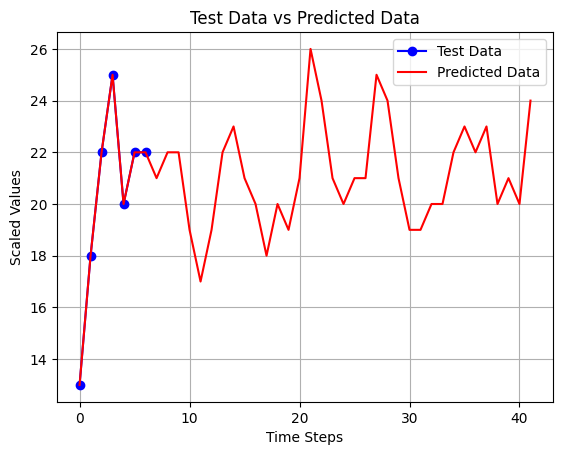

In [71]:
plt.plot(x_test[-1], label='Test Data', color='blue', marker='o')
plt.plot(np.hstack([x_test[-1], y_next_30.reshape(-1)]), label='Predicted Data', color='red')
plt.title('Test Data vs Predicted Data')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Values')
plt.legend()
plt.grid(True)
plt.show()

In [72]:
last_date = clean_df.index[-1]
total_sub = np.sum(np.array(clean_df['Subscribers']))
total_next_30 = np.sum(y_next_30)
print(f"Total subscribers till {last_date}: {total_sub}, next_30_days: {np.round(total_next_30)} => final after 30 days: {total_sub + round(total_next_30)}")

Total subscribers till 2024-12-12 00:00:00: 8117, next_30_days: 740.0 => final after 30 days: 8857


In [73]:
avg_sub = np.mean(np.array(clean_df['Subscribers']))
avg_sub * 30

393.3925686591276